In [6]:
import cPickle
import gzip
import numpy as np

data_file = gzip.open('mnist.pkl.gz','rb')
train, test, validation = cPickle.load(data_file)

train_features = train[0]
train_labels = train[1]

test_features = test[0]
test_labels = test[1]

validation_features = validation[0]
validation_labels = validation[1]

usps_file = gzip.open('usps_data.pkl.gz','rb')
usps_features,usps_labels = cPickle.load(usps_file)

print "Data Loaded"

Data Loaded


In [7]:
train_all = np.hstack([train_features, train_labels.reshape(len(train_labels),1)])
np.random.shuffle(train_all)

train_features=train_all[:,:train[0].shape[1]]
train_labels = train_all[:,train[0].shape[1]].astype(train[1].dtype)

print "Training data shuffled"

Training data shuffled


In [8]:
import numpy as np

class SimpleNN:
    
    def __init__(self, X, Y, alpha=0.001, regularizer=0.0):
        self.X = X
        self.Y = Y
        self.alpha = alpha
        self.regularizer = regularizer
        self.layer_one_weights = None
        self.layer_two_weights = None
        self.layer_two_z = None
        self.layer_three_z = None
        self.layer_two_a = None
        self.layer_three_a = None
        self.layer_two_delta = None
        self.layer_three_delta = None
        self.__initX()
        self.__oneHotEncodeY()
        self.__initWeights()
    
    def __initX(self):
        x0 = np.ones((self.X.shape[0],1)).astype(self.X.dtype)
        self.X = np.hstack([x0,self.X])
        
    def __initWeights(self):
        self.layer_one_weights = np.random.normal(loc=0, scale=(1.0/self.X.shape[1]**(0.5)), size=(self.X.shape[1], self.X.shape[1]+1))
        #self.layer_one_weights = np.random.uniform(low=-0.012, high=0.012, size=(self.X.shape[1], self.X.shape[1]+1))
        #self.layer_two_weights = np.random.uniform(low=-0.012, high=0.012, size=(self.layer_one_weights.shape[1], self.Y.shape[1]))
        self.layer_two_weights = np.random.uniform(size=(self.layer_one_weights.shape[1], self.Y.shape[1])) / np.sqrt(self.layer_one_weights.shape[1])
        
    def __softmax(self,x):
        #x[x>=0] *= -1.0
        z = np.exp(x)
        return z / np.sum(z,axis=1,keepdims=True)
    
    def __oneHotEncodeY(self):
        encoded_Y = np.zeros((self.Y.size, self.Y.max()+1), dtype=self.Y.dtype)
        encoded_Y[np.arange(self.Y.size), self.Y] = 1
        self.Y = encoded_Y
    
    def __oneHotEncode(self, vector):
        encoded_vector = np.zeros((vector.size, vector.max()+1), dtype=vector.dtype)
        encoded_vector[np.arange(vector.size), vector] = 1
        return encoded_vector
    
    def __cost(self):
        num_samples = self.X.shape[0]
        term_one = -1.0 * np.sum(self.Y*np.log(self.layer_three_a)) / num_samples
        return term_one + ((self.regularizer/2) * (np.sum(self.layer_one_weights * self.layer_one_weights)+np.sum(self.layer_two_weights * self.layer_two_weights)))
    
    def __forward(self):
        self.layer_two_z = self.X.dot(self.layer_one_weights)
        self.layer_two_a = np.tanh(self.layer_two_z)
        self.layer_three_z = self.layer_two_a.dot(self.layer_two_weights)
        self.layer_three_a = self.__softmax(self.layer_three_z)
        
    def __backward(self):
        self.layer_three_delta = self.layer_three_a - self.Y
        derivative = (1.0 - self.layer_two_z * self.layer_two_z)
        self.layer_two_delta = self.layer_three_delta.dot(self.layer_two_weights.T) * derivative
        
        layer_one_weights_gradient = self.X.T.dot(self.layer_two_delta) / self.X.shape[0]
        layer_two_weights_gradient = self.layer_two_z.T.dot(self.layer_three_delta) / self.X.shape[0]
        
        layer_one_weights_gradient += self.regularizer * self.layer_one_weights / self.X.shape[0]
        layer_two_weights_gradient += self.regularizer * self.layer_two_weights / self.X.shape[0]
        
        self.layer_one_weights += -self.alpha * layer_one_weights_gradient
        self.layer_two_weights += -self.alpha * layer_two_weights_gradient
        
    def train(self, epochs=50, status_epochs=10, return_cost_progress=False):
        if return_cost_progress:
            cost_progress = np.zeros((epochs, 2))
        train_features_batches = np.array_split(self.X, 1)
        train_labels_batches = np.array_split(self.Y, 1)
        current_epoch = 0
        while current_epoch < epochs:
            for b in range(len(train_features_batches)):
                self.X = train_features_batches[b]
                self.Y = train_labels_batches[b]
                self.__forward()
                self.__backward()
            
            if return_cost_progress:
                cost_progress[current_epoch][0] = current_epoch
                cost_progress[current_epoch][1] = self.__cost()
            
            if current_epoch % status_epochs == 0:
                print "Epoch ", current_epoch
                #print "W1: ",self.layer_one_weights[:10,:10]
                #print "W2: ",self.layer_two_weights[:10,:10]
            current_epoch += 1
        if return_cost_progress:
            return cost_progress
        else:
            return
        
    def predict(self, X):
        x0 = np.ones((X.shape[0],1)).astype(X.dtype)
        X_test = np.hstack([x0,np.copy(X)])
        if X_test.shape[1] != self.X.shape[1]:
            print "Number of features in test data and training data do not match!"
            print ""
        self.layer_two_z = X_test.dot(self.layer_one_weights)
        self.layer_two_a = np.tanh(self.layer_two_z)
        self.layer_three_z = self.layer_two_a.dot(self.layer_two_weights)
        numerator = np.exp(self.layer_three_z)
        denominator = np.sum(numerator, axis=1, keepdims=True)
        return np.argmax(numerator/denominator, axis=1)
        
    def error(self, Y_pred, Y_actual):
        num_wrong = Y_pred[Y_pred != Y_actual].size
        num_total = Y_pred.size
        return 1.0*num_wrong / num_total
    
    def accuracy(self, Y_pred, Y_actual):
        num_right = Y_pred[Y_pred == Y_actual].size
        num_total = Y_pred.size
        return 1.0*num_right / num_total


Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Epoch  100
Epoch  110
Epoch  120
Epoch  130
Epoch  140
Epoch  150
Epoch  160
Epoch  170
Epoch  180
Epoch  190
Epoch  200
Epoch  210
Epoch  220
Epoch  230
Epoch  240
Epoch  250
Epoch  260
Epoch  270
Epoch  280
Epoch  290
Trained in  1082.68  seconds
Test Error:  0.0819
Test Accuracy:  0.9181
Validation Error:  0.0832
Validation Accuracy:  0.9168
USPS Error:  0.435121756088
USPS Accuracy:  0.564878243912


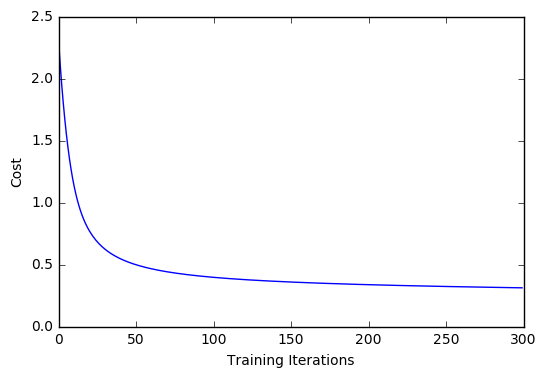

In [9]:
from time import time

simple_nn = SimpleNN(train_features, train_labels, 0.2)
t_nn = time()
cost_progress = simple_nn.train(300,10,return_cost_progress=True)
print "Trained in ", round(time()-t_nn,2)," seconds"

'''
print "Predicted Labels: ", pred_labels[:10]
print "Actual Labels: ", test_labels[:10]
'''
pred_labels = simple_nn.predict(test_features)
err = simple_nn.error(pred_labels, test_labels)
print "Test Error: ",err
acc = simple_nn.accuracy(pred_labels, test_labels)
print "Test Accuracy: ",acc

v_pred_labels = simple_nn.predict(validation_features)
v_err = simple_nn.error(v_pred_labels, validation_labels)
print "Validation Error: ",v_err
v_acc = simple_nn.accuracy(v_pred_labels, validation_labels)
print "Validation Accuracy: ",v_acc

usps_pred_labels = simple_nn.predict(usps_features)
usps_err = simple_nn.error(usps_pred_labels, usps_labels)
usps_acc = simple_nn.accuracy(usps_pred_labels, usps_labels)
print "USPS Error: ",usps_err
print "USPS Accuracy: ",usps_acc

%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(cost_progress[:,0], cost_progress[:,1])
plt.xlabel('Training Iterations')
plt.ylabel('Cost')
plt.show()